<a href="https://colab.research.google.com/github/stevengregori92/Learn-XGBoost/blob/main/Creditcard_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji
!gdown https://drive.google.com/uc?id=1tDU2zqNG76hXrG65aFWjYFXfDhB626OT
!unzip /content/creditcardfraud.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.2 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366829 sha256=e1898d304267fecc0d02dbc600dc7a553a2f31f074a7638dc1ceb33e1f9fd9fa
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32179 sha256=7f2f2a6af3f2b38162f6627802a46427206727b5e4b17e8cc57ce16a613dc4f7
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml
Downloading...
From: https://drive.google.com/uc?id=1tDU2zqNG76hXrG65aFWjYFXfDhB626OT
To: /content/creditcardfraud.zip


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [3]:
df = pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
len(df)

1000000

In [5]:
df = df.loc[:10000]

#Dataset Split

In [6]:
X = df.drop(columns=['fraud'])
y = df.fraud

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 7), (2001, 7), (8000,), (2001,))

#PCA

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
pca = PCA().fit(X_train)

Text(0, 0.5, 'Cumulative Explained Variance')

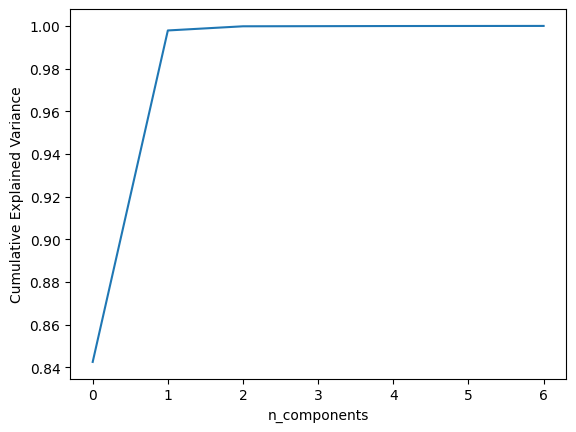

In [9]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')

#Training

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=3, whiten=True)),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.379884089544096, 'algo__gamma': 8, 'algo__learning_rate': 0.2147062631022881, 'algo__max_depth': 8, 'algo__n_estimators': 185, 'algo__reg_alpha': 3.5387588647792456, 'algo__reg_lambda': 0.0774211647399625, 'algo__subsample': 0.35979712296915084}
0.93575 0.9356246541950449 0.9370314842578711


#Feature Importance

,feature,importance,stdev
2,ratio_to_median_purchase_price,0.098100,0.001210
0,distance_from_home,0.001175,0.000430
1,distance_from_last_transaction,0.000400,0.000166
3,repeat_retailer,0.000000,0.000000
4,used_chip,0.000000,0.000000
5,used_pin_number,0.000000,0.000000
6,online_order,0.000000,0.000000


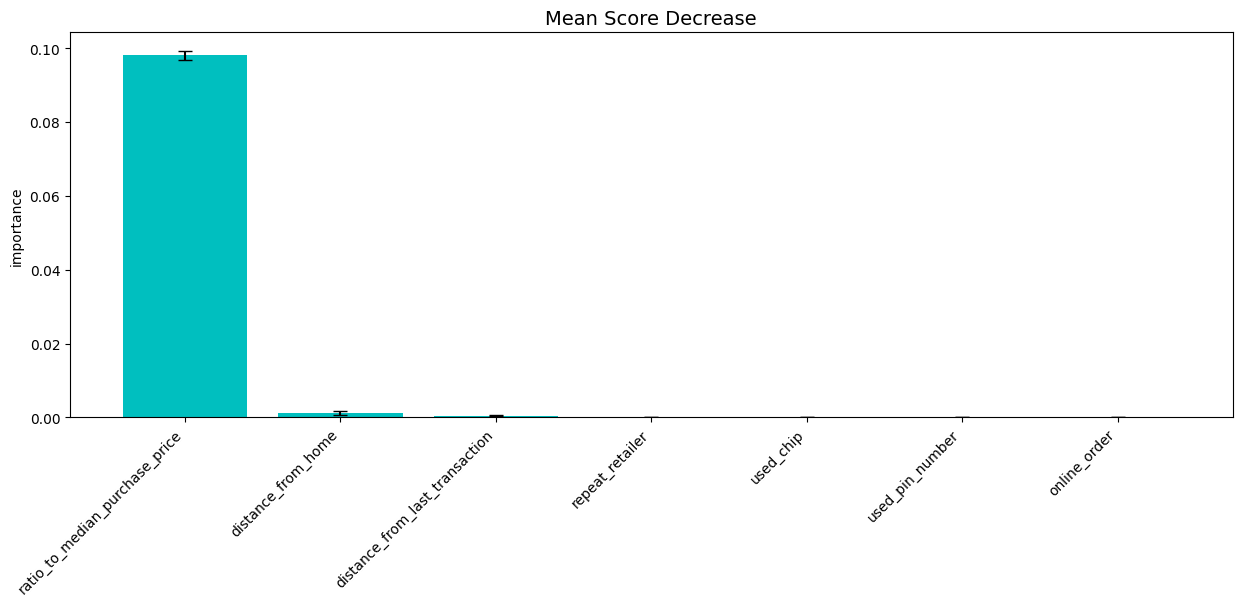

In [12]:
mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [13]:
X_train.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order'],
      dtype='object')

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['ratio_to_median_purchase_price', 'distance_from_home',
                             'distance_from_last_transaction', 'used_pin_number'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=3, whiten=True)),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7048235217656795, 'algo__gamma': 3, 'algo__learning_rate': 0.08534852819566893, 'algo__max_depth': 6, 'algo__n_estimators': 157, 'algo__reg_alpha': 2.7645119606152053, 'algo__reg_lambda': 0.010023177978572915, 'algo__subsample': 0.3194173672147116}
0.941375 0.9357494979294129 0.9365317341329336
